In this notebook, I compare the total snow depth to change in snow depth based on scatter plot.
Workflow:

In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import rioxarray
import xarray as xr
from rasterio.enums import Resampling

In [2]:
#print working directory
print(os.getcwd())

/home/naheemadebisi/snow-analytics/lowman


In [3]:
#Read UAVSAR and lidar files
#open UAVSAR raster file

Jan15_20 = rioxarray.open_rasterio('MCS2/MCS_15_20Jan2021_snow_diff.tif')
Jan20_27 = rioxarray.open_rasterio('MCS2/MCS_20_27Jan2021_snow_diff.tif')
Jan27_03 = rioxarray.open_rasterio('MCS2/MCS_27_03Feb2021_snow_diff.tif')
Feb03_10 = rioxarray.open_rasterio('MCS2/MCS_03_10Feb2021_snow_diff.tif')
Feb10_03 = rioxarray.open_rasterio('MCS2/MCS_feb10_03Mar2021other_snow_diff.tif')
Mar03_10 = rioxarray.open_rasterio('MCS2/MCS_03_10Mar2021_snow_diff.tif')
Mar10_16 = rioxarray.open_rasterio('MCS2/MCS_10_16Mar2021_snow_diff.tif')
Mar16_22 = rioxarray.open_rasterio('MCS2/MCS_16_22Mar2021_snow_diff.tif')

arr_list = [Jan15_20, Jan20_27, Jan27_03, Feb03_10, Feb10_03, Mar03_10, Mar10_16, Mar16_22]

lidar = rioxarray.open_rasterio('/home/naheemadebisi/snow-analytics/Western-Snow-Conference/QSI_DEMs/MCS_15Mar21_snowdepth_diff.tif')

## reproject_to match for all UAVSAR files

In [4]:
#Define a clip polygon 
cropping_geometries = [{
    'type': 'Polygon',
    'coordinates':[
        [[604276,4863907], [601703,4867245], [606245,4870497], [608397,4866855]]
        ]
}]

In [5]:
#Create a list of dates attributes for the UAVSAR 
acquisition_period = ['Jan15-Jan20', 'Jan20-Jan27', 'Jan27-Feb03', 'Feb03-Feb10', 'Feb10-Mar03','Mar03-Mar10', 'Mar10-Mar16', 'Mar16-Mar22']
acquisition_period_b = ['01-15-2021_01-20-2021', '01-20-2021_01-27-2021', '01-27-2021_02-03-2021', '02-03-2021_02-10-2021', '02-10-2021_03-03-2021', 
                        '03-03-2021_03-10-2021', '03-10-2021_03-16-2021', '03-16-2021_03-22-2021']

In [6]:
#Clip the UAVSAR rasters
arr_list_clip = []
for i in range(len(arr_list)):
    arr_list_clip.append(arr_list[i].rio.clip(cropping_geometries, crs=31965))
    arr_list_clip[i].name = acquisition_period[i]
    arr_list_clip[i].attrs['acquisition_period_b'] = acquisition_period_b[i]
    arr_list_clip[i].attrs['sensor_polarization'] = 'VV'
    arr_list_clip[i].attrs['location'] = 'lowman'

In [7]:
#Clip the lidar raster and add info to the xarrays
lidar = lidar.rio.clip(cropping_geometries, crs=31965)
lidar.name = 'lidar'
lidar.attrs['acquisition_period_b'] = 'lidar:Mar-15'
lidar.attrs['location'] = 'lowman'

In [30]:
lidar.min()

<xarray.DataArray 'lidar' ()>
array(-15.37085, dtype=float32)
Coordinates:
    spatial_ref  int64 0

In [8]:
#append the lidar data
arr_list_clip.append(lidar)

In [9]:
#reproject to match for all rasters
arr_list_clip_reproj = []
for i in range(len(arr_list_clip)):
    arr_list_clip_reproj.append(arr_list_clip[i].rio.reproject_match(arr_list_clip[0]))
    arr_list_clip_reproj[i] = arr_list_clip_reproj[i].where(arr_list_clip_reproj[i] != 3.4028234663852886e+38)

In [10]:
#define a function to view the spatial extent of the rasters
def print_raster(raster):
    print(
        f"name: {raster.attrs['acquisition_period_b']}\n"
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"min: {raster.min().item()}\n"
        f"max: {raster.max().item()}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )

In [11]:
#first raster file
print_raster(arr_list_clip_reproj[0])

name: 01-15-2021_01-20-2021
shape: (763, 1358)
resolution: (6.131393741159328e-05, -7.73899093760838e-05)
bounds: (-115.73249504195634, 43.920889191253046, -115.6492307149514, 43.979937692107)
min: -23.381986618041992
max: 45.98967361450195
sum: -1071220.25
CRS: EPSG:4326



In [12]:
#second raster file
print_raster(arr_list_clip_reproj[1])

name: 01-20-2021_01-27-2021
shape: (763, 1358)
resolution: (6.131393741159328e-05, -7.73899093760838e-05)
bounds: (-115.73249504195634, 43.920889191253046, -115.6492307149514, 43.979937692107)
min: -26.05023193359375
max: 24.55891990661621
sum: -1334403.875
CRS: EPSG:4326



In [13]:
#last raster file:lidar
print_raster(arr_list_clip_reproj[-1])

name: lidar:Mar-15
shape: (763, 1358)
resolution: (6.131393741159328e-05, -7.73899093760838e-05)
bounds: (-115.73249504195634, 43.920889191253046, -115.6492307149514, 43.979937692107)
min: -11.1324462890625
max: 19.70458984375
sum: 927691.25
CRS: EPSG:4326



## Replace the fill_values with NAN

## Plot the rasters

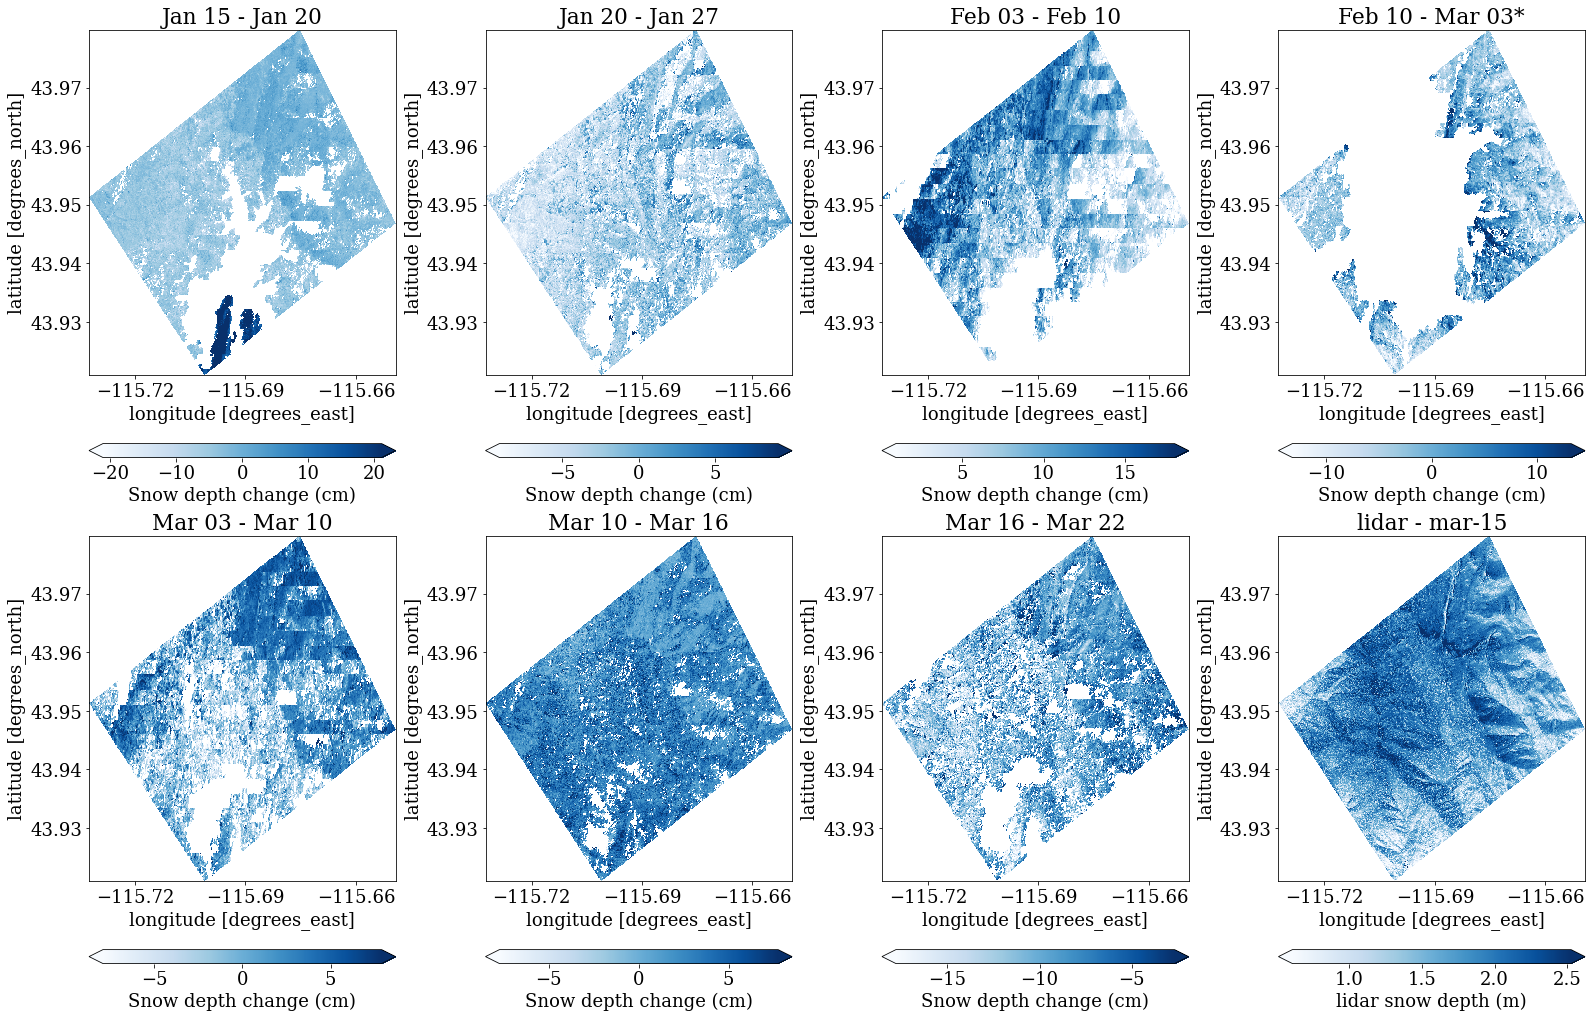

In [14]:
#create a figure and axes elements
# Set font size and font family
plt.rcParams.update({'font.size': 18})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(22,14), constrained_layout=True)

arr_list_clip_reproj[0].plot(ax=ax[0,0], cmap='Blues', robust = True, cbar_kwargs={'label': 'Snow depth change (cm)', 'orientation': 'horizontal'})
ax[0,0].set_title('Jan 15 - Jan 20')
ax[0,0].xaxis.set_major_locator(plt.MaxNLocator(3))
arr_list_clip_reproj[1].plot(ax=ax[0,1], cmap='Blues', robust = True, cbar_kwargs={'label': 'Snow depth change (cm)', 'orientation': 'horizontal'})
ax[0,1].set_title('Jan 20 - Jan 27')
ax[0,1].xaxis.set_major_locator(plt.MaxNLocator(3))
# arr_list_clip_reproj[2].plot(ax=ax[0,2], cmap='Blues', robust = True, cbar_kwargs={'label': 'Snow depth change(cm)', 'orientation': 'horizontal'})
# ax[0,2].set_title('Jan 27 - Feb 03') #No data
arr_list_clip_reproj[3].plot(ax=ax[0,2], cmap='Blues', robust = True, cbar_kwargs={'label': 'Snow depth change (cm)', 'orientation': 'horizontal'})
ax[0,2].set_title('Feb 03 - Feb 10')
ax[0,2].xaxis.set_major_locator(plt.MaxNLocator(3))
arr_list_clip_reproj[4].plot(ax=ax[0,3], cmap='Blues', robust = True, cbar_kwargs={'label': 'Snow depth change (cm)', 'orientation': 'horizontal'})
ax[0,3].set_title('Feb 10 - Mar 03*')
ax[0,3].xaxis.set_major_locator(plt.MaxNLocator(3))
arr_list_clip_reproj[5].plot(ax=ax[1,0], cmap='Blues', robust = True, cbar_kwargs={'label': 'Snow depth change (cm)', 'orientation': 'horizontal'})
ax[1,0].set_title('Mar 03 - Mar 10')
ax[1,0].xaxis.set_major_locator(plt.MaxNLocator(3))
arr_list_clip_reproj[6].plot(ax=ax[1,1], cmap='Blues', robust = True, cbar_kwargs={'label': 'Snow depth change (cm)', 'orientation': 'horizontal'})
ax[1,1].set_title('Mar 10 - Mar 16')
ax[1,1].xaxis.set_major_locator(plt.MaxNLocator(3))
arr_list_clip_reproj[7].plot(ax=ax[1,2], cmap='Blues', robust = True, cbar_kwargs={'label': 'Snow depth change (cm)', 'orientation': 'horizontal'})
ax[1,2].set_title('Mar 16 - Mar 22')
ax[1,2].xaxis.set_major_locator(plt.MaxNLocator(3))
arr_list_clip_reproj[8].plot(ax=ax[1,3], cmap='Blues', robust = True, cbar_kwargs={'label': 'lidar snow depth (m)', 'orientation': 'horizontal'})
ax[1,3].set_title('lidar - mar-15')
ax[1,3].xaxis.set_major_locator(plt.MaxNLocator(3))

#save the figure
#plt.savefig('/home/naheemadebisi/snow-analytics/lowman/MCS2/MCS_snowdepth_timeseries.jpeg', dpi=500)
plt.show()



In [15]:
df = [] 
for i in range(len(arr_list_clip_reproj)):
    df.append((arr_list_clip_reproj[i].squeeze().drop('spatial_ref').drop('band')).to_dataframe())

In [16]:
df

[                       Jan15-Jan20
 y         x                       
 43.979899 -115.732464          NaN
           -115.732403          NaN
           -115.732342          NaN
           -115.732280          NaN
           -115.732219          NaN
 ...                            ...
 43.920928 -115.649507          NaN
           -115.649445          NaN
           -115.649384          NaN
           -115.649323          NaN
           -115.649261          NaN
 
 [1036154 rows x 1 columns],
                        Jan20-Jan27
 y         x                       
 43.979899 -115.732464          NaN
           -115.732403          NaN
           -115.732342          NaN
           -115.732280          NaN
           -115.732219          NaN
 ...                            ...
 43.920928 -115.649507          NaN
           -115.649445          NaN
           -115.649384          NaN
           -115.649323          NaN
           -115.649261          NaN
 
 [1036154 rows x 1 columns],
  

In [17]:
df[0]

Jan15-Jan20
y         x                       
43.979899 -115.732464          NaN
          -115.732403          NaN
          -115.732342          NaN
          -115.732280          NaN
          -115.732219          NaN
...                            ...
43.920928 -115.649507          NaN
          -115.649445          NaN
          -115.649384          NaN
          -115.649323          NaN
          -115.649261          NaN

[1036154 rows x 1 columns]

In [18]:
df[-1]

lidar
y         x                 
43.979899 -115.732464    NaN
          -115.732403    NaN
          -115.732342    NaN
          -115.732280    NaN
          -115.732219    NaN
...                      ...
43.920928 -115.649507    NaN
          -115.649445    NaN
          -115.649384    NaN
          -115.649323    NaN
          -115.649261    NaN

[1036154 rows x 1 columns]

In [28]:
df[-1].max()

lidar    19.70459
dtype: float32

In [23]:
merged_df = pd.concat(df, axis=1)
merged_df #don't drop nan, else you lose all files

Jan15-Jan20  Jan20-Jan27  Jan27-Feb03  Feb03-Feb10  \
y         x                                                                 
43.979899 -115.732464          NaN          NaN          NaN          NaN   
          -115.732403          NaN          NaN          NaN          NaN   
          -115.732342          NaN          NaN          NaN          NaN   
          -115.732280          NaN          NaN          NaN          NaN   
          -115.732219          NaN          NaN          NaN          NaN   
...                            ...          ...          ...          ...   
43.920928 -115.649507          NaN          NaN          NaN          NaN   
          -115.649445          NaN          NaN          NaN          NaN   
          -115.649384          NaN          NaN          NaN          NaN   
          -115.649323          NaN          NaN          NaN          NaN   
          -115.649261          NaN          NaN          NaN          NaN   

                       Feb10-Mar03  Mar03-Mar10  Mar10-Mar16  Mar16-Mar22  \
y         x                                                                 
43.979899 -115.732464          NaN          NaN          NaN          NaN   
          -115.732403          NaN          NaN          NaN          NaN   
          -115.732342          NaN          NaN          NaN          NaN   
          -115.732280          NaN          NaN          NaN          NaN   
          -115.732219          NaN          NaN          NaN          NaN   
...                            ...          ...          ...          ...   
43.920928 -115.649507          NaN          NaN          NaN          NaN   
          -115.649445          NaN          NaN          NaN          NaN   
          -115.649384          NaN          NaN          NaN          NaN   
          -115.649323          NaN          NaN          NaN          NaN   
          -115.649261          NaN          NaN          NaN          NaN   

                       lidar  
y         x                   
43.979899 -115.732464    NaN  
          -115.732403    NaN  
          -115.732342    NaN  
          -115.732280    NaN  
          -115.732219    NaN  
...                      ...  
43.920928 -115.649507    NaN  
          -115.649445    NaN  
          -115.649384    NaN  
          -115.649323    NaN  
          -115.649261    NaN  

[1036154 rows x 9 columns]

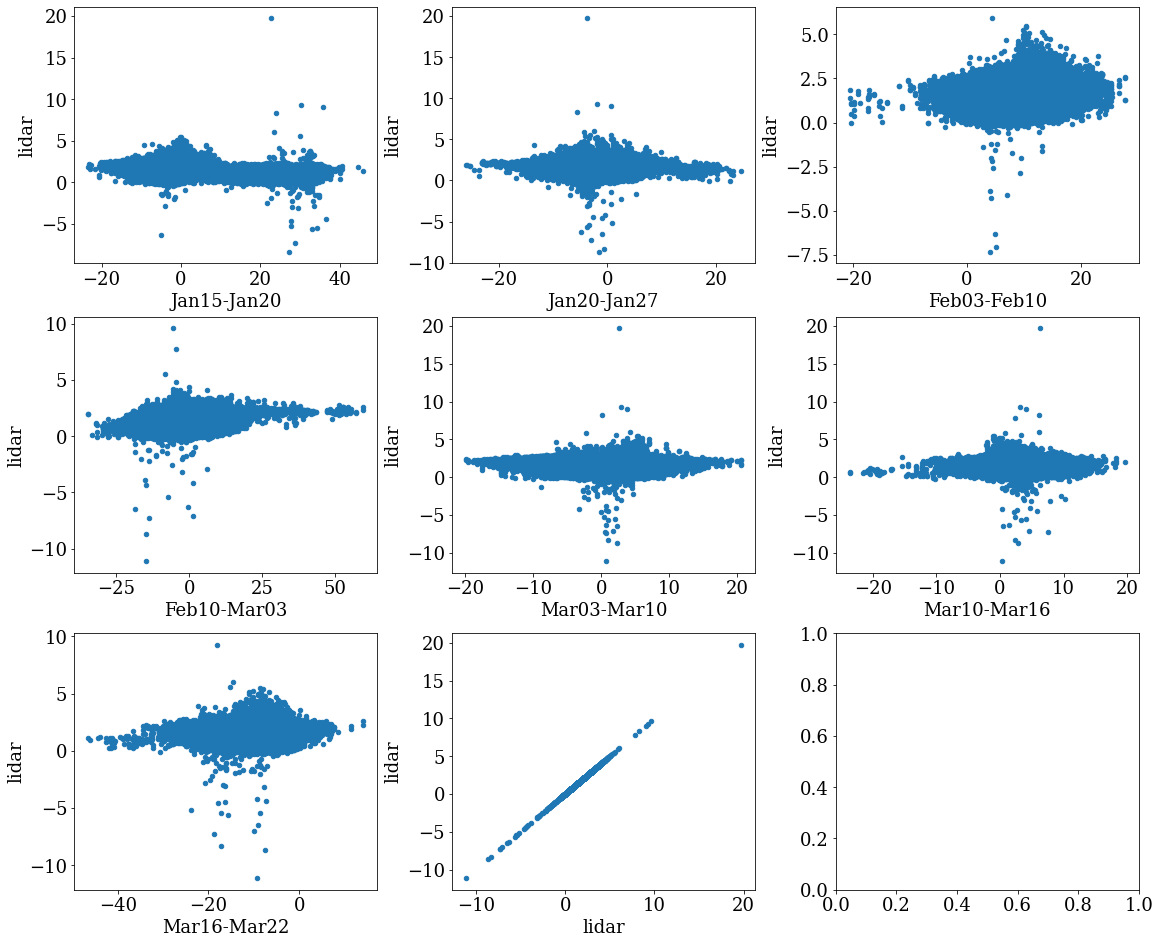

In [50]:
# Set font size and font family
plt.rcParams.update({'font.size': 18})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

#create a figure of 7 axes
fig, axs = plt.subplots(3, 3, figsize=(16, 13), constrained_layout = True)

ax = axs.flatten()

merged_df.plot.scatter(x='Jan15-Jan20', y = 'lidar', ax = ax[0])
merged_df.plot.scatter(x='Jan20-Jan27', y = 'lidar', ax = ax[1])
merged_df.plot.scatter(x='Feb03-Feb10', y = 'lidar', ax = ax[2])
merged_df.plot.scatter(x='Feb10-Mar03', y = 'lidar', ax = ax[3])
merged_df.plot.scatter(x='Mar03-Mar10', y = 'lidar', ax = ax[4])
merged_df.plot.scatter(x='Mar10-Mar16', y = 'lidar', ax = ax[5])
merged_df.plot.scatter(x='Mar16-Mar22', y = 'lidar', ax = ax[6])
merged_df.plot.scatter(x='lidar', y = 'lidar', ax = ax[7])
#save the figure

#plt.savefig('/home/naheemadebisi/snow-analytics/lowman/uavsar-lidar-scatter.jpeg', dpi=500)

plt.show()

In [ ]:
#Regression line

In [19]:
# #Resample dataset

# upscale_factor = 0.5
# new_width = lidar_rp_match.rio.width * upscale_factor
# new_height = lidar_rp_match.rio.height * upscale_factor

# lidar_rp_match_down = lidar_rp_match.rio.reproject(
#     lidar_rp_match.rio.crs,
#     shape=(int(new_height), int(new_width)),
#     resampling=Resampling.bilinear,
# )

NameError: name 'lidar_rp_match' is not defined

In [ ]:
lidar_rp_match

<xarray.DataArray 'lidar' (band: 1, y: 763, x: 1358)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 -115.7 -115.7 -115.7 ... -115.6 -115.6 -115.6
  * y            (y) float64 43.98 43.98 43.98 43.98 ... 43.92 43.92 43.92 43.92
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:          1.0
    add_offset:            0.0
    _FillValue:            3.402823466e+38
    acquisition_period_b:  Mar-15
    location:              lowman

In [ ]:
lidar_rp_match_down

<xarray.DataArray 'lidar' (band: 1, y: 381, x: 679)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 -115.7 -115.7 -115.7 ... -115.6 -115.6 -115.6
  * y            (y) float64 43.98 43.98 43.98 43.98 ... 43.92 43.92 43.92 43.92
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:          1.0
    add_offset:            0.0
    acquisition_period_b:  Mar-15
    location:              lowman
    _FillValue:            3.4028235e+38

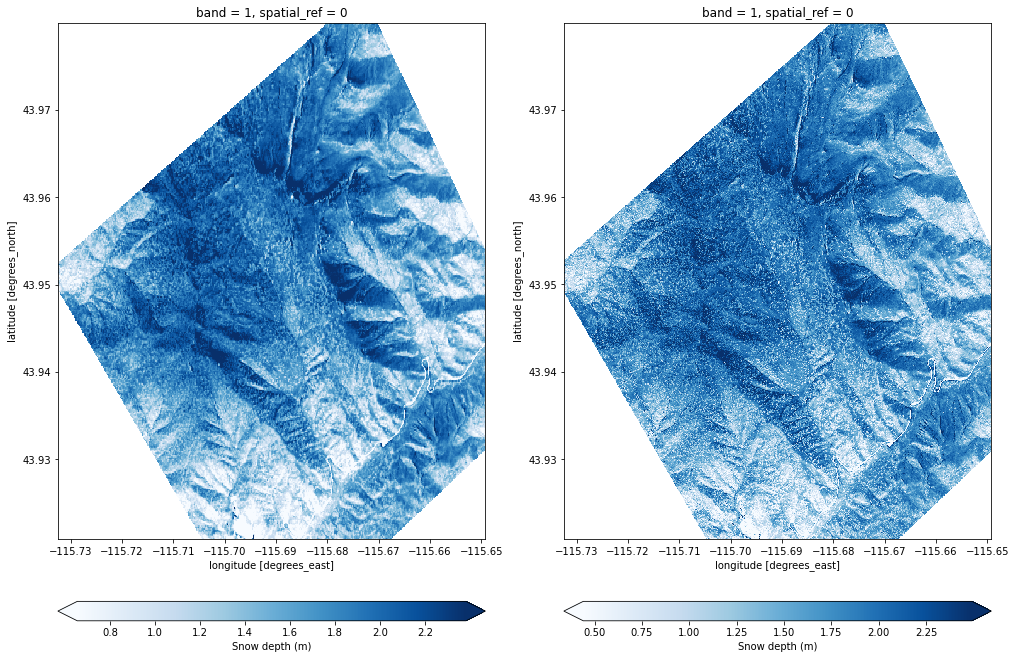

In [ ]:
#plot two columns
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,9), constrained_layout=True)

lidar_rp_match_down.plot(ax=ax[0], cmap='Blues', robust = True, cbar_kwargs={'label': 'Snow depth (m)', 'orientation': 'horizontal'})
lidar_rp_match.plot(ax= ax[1], cmap = 'Blues', robust = True, cbar_kwargs={'label': 'Snow depth (m)', 'orientation': 'horizontal'})